In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from torchvision.models import resnet18
from torch.utils.data import random_split, DataLoader


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [3]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_subset, val_subset = torch.utils.data.random_split(
        trainset, [int(len(trainset) * 0.8), int(len(trainset) * 0.2)],
    generator=torch.Generator().manual_seed(1))


In [5]:

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


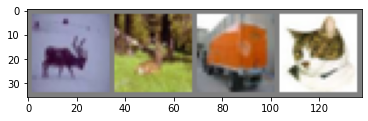

 deer  deer truck   cat


In [7]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [8]:
images.shape

torch.Size([4, 3, 32, 32])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,  10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [10]:
cuda = torch.device('cuda')

In [11]:
# net = Net().to(cuda)
net = resnet18(pretrained=False, num_classes=10).to(cuda)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
running_loss_window = 2000
writer = SummaryWriter(log_dir='cifar_easy')
patience = 5
prev_val_loss = 9999
trigger_times = 0

In [13]:
len(trainloader)

10000

In [ ]:
class CifarDataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str = './', transforms = None, batch_size = 4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size 
        
        if transforms is None:
            transform = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        else:
            self.transform = transforms

        # self.dims is returned when you call dm.size()
        # Setting default dims here because we know them.
        # Could optionally be assigned dynamically in dm.setup()

    def prepare_data(self):
        # download
        torchvision.datasets.CIFAR10(root=self.data_dir, train=True,
                                        download=True)
        torchvision.datasets.CIFAR10(root=self.data_dir, train=False,
                                       download=True)

    def setup(self, stage: Optional[str] = None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            trainset = torchvision.datasets.CIFAR10(
                root=self.data_dir, train=True, transform=self.transform)
            self.train_subset, self.val_subset = 
                    random_split(trainset, [int(len(trainset) * 0.8), int(len(trainset) * 0.2)])

            self.dims = tuple(self.train_subset[0][0].shape)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.testset = torchvision.datasets.CIFAR10(
                root=self.data_dir, train=False, transform=self.transform)

            self.dims = tuple(self.testset[0][0].shape)

    def train_dataloader(self):
        return DataLoader(self.train_subset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_subset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size)


## example
# dm = CifarDataModule()
# dm.prepare_data()
# dm.setup(stage='fit')

# model = Model(num_classes=dm.num_classes, width=dm.width, vocab=dm.vocab)
# trainer.fit(model, dm)

# dm.setup(stage='test')
# trainer.test(datamodule=dm)


In [ ]:
# lightening
class LitNet(pl.LightningModule):
    def __init__(self, model, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        prediction = self.model(x)
        return prediction

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        inputs, labels = batch

        outputs = self.model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch

        outputs = self.model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        self.log('val_acc', acc)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my/path/',
    filename='sample-mnist-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

trainer = Trainer(callbacks=[early_stop_callback, checkpoint_callback])


In [ ]:
# example
dm = CifarDataModule()
dm.prepare_data()
dm.setup(stage='fit')

model = Model(num_classes=dm.num_classes)
trainer.fit(model, dm)

dm.setup(stage='test')
trainer.test(datamodule=dm)


In [14]:
step = 0
for epoch in range(20):
    running_loss = 0.0
    net.train()
    total, correct = 0, 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(cuda), labels.to(cuda)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        if (i + 1) % running_loss_window == 0:
            step += 1
            avg_loss = running_loss / running_loss_window
            print(f"{epoch + 1}, {i + 1} loss: {avg_loss}")
            writer.add_scalar('Loss/train', avg_loss, step)
            running_loss = 0.0
            
    val_loss = 0
    n_val = len(validloader)
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(cuda), labels.to(cuda)
            outputs.pred = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

            val_loss += loss.item() 
    val_loss /= n_val
    print(f'pre_val_loss: {prev_val_loss},val_loss: {val_loss}')
    writer.add_scalar('Loss/valid', val_loss, step)
    
    if val_loss > prev_val_loss:
        trigger_times += 1
        print(f'trigger times: {trigger_times}')
        
        if trigger_times >= patience:
            print('Early stopping!\n')
            break
    else:
        print(f'reset trigger times: 0')
        trigger_times = 0
        torch.save(net, f'easy_epoch_{epoch}.pkl')
    prev_val_loss = val_loss


                

1, 2000 loss: 2.1605539583563806
1, 4000 loss: 1.840511369228363
1, 6000 loss: 1.6747965853214264
1, 8000 loss: 1.6067349349856377
1, 10000 loss: 1.5341804790496827
pre_val_loss: 9999,val_loss: 3.3977914556980133
reset trigger times: 0
2, 2000 loss: 1.4605249365866184
2, 4000 loss: 1.4295453011915087
2, 6000 loss: 1.3923039456680417
2, 8000 loss: 1.363248693987727
2, 10000 loss: 1.3505309981182219
pre_val_loss: 3.3977914556980133,val_loss: 4.962393927407264
trigger times: 1
3, 2000 loss: 1.2662562084570528
3, 4000 loss: 1.2584862017855047
3, 6000 loss: 1.245534930795431
3, 8000 loss: 1.2170082848370076
3, 10000 loss: 1.2194487814363093
pre_val_loss: 4.962393927407264,val_loss: 4.291744531488418
reset trigger times: 0
4, 2000 loss: 1.1272569461800157
4, 4000 loss: 1.1525102120246737
4, 6000 loss: 1.1560372970551251
4, 8000 loss: 1.1211029207855463
4, 10000 loss: 1.1288282944057138
pre_val_loss: 4.291744531488418,val_loss: 5.107427136349678
trigger times: 1
5, 2000 loss: 1.03660321620432

In [ ]:
with torch.no_grad():
    for data in testloader:


In [1]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


NameError: name 'val_loss' is not defined